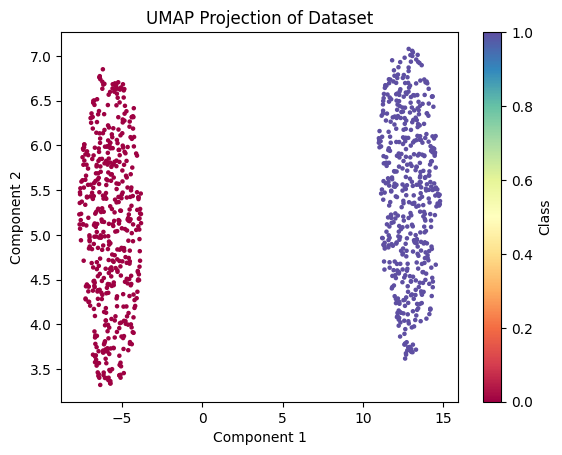

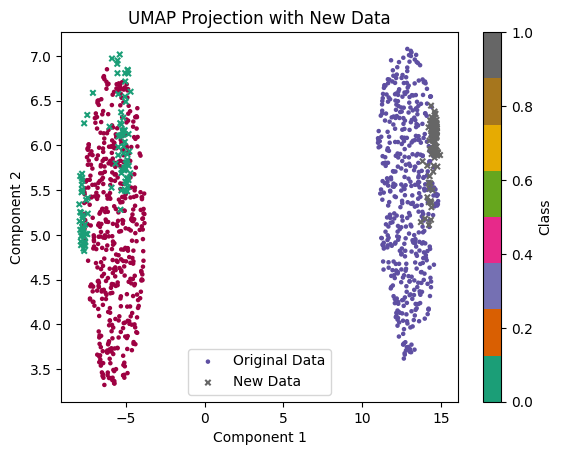

In [6]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Tạo dữ liệu giả lập
n_samples = 1000
n_features = 10
n_classes = 2
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, random_state=42)

# Khởi tạo UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)


# Huấn luyện UMAP trên dữ liệu ban đầu
X_embedded = reducer.fit_transform(X)

# Biểu diễn dữ liệu giảm chiều
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='Spectral', s=5)
plt.colorbar(label="Class")
plt.title("UMAP Projection of Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Giả lập thêm dữ liệu mới
new_samples = 200
X_new, y_new = make_blobs(n_samples=new_samples, n_features=n_features, centers=n_classes, random_state=100)

# Giảm chiều dữ liệu mới bằng mô hình đã học
X_new_embedded = reducer.transform(X_new)

# Biểu diễn dữ liệu mới trên không gian giảm chiều
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='Spectral', s=5, label="Original Data")
plt.scatter(X_new_embedded[:, 0], X_new_embedded[:, 1], c=y_new, cmap='Dark2', s=15, marker='x', label="New Data")
plt.colorbar(label="Class")
plt.title("UMAP Projection with New Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()